## 数据概览  
  
本次使用的是一个休闲类闯关手游的数据，用户在游戏中不断闯关，每一关的基本任务是在限定步数内达到某个目标。每次闯关可能成功也可能失败，一般情况下用户只在完成一关后进入下一关，闯关过程中可以使用道具或提示等帮助。  
  
对大多数手游来说，用户流失往往发生在早期，因此次周的留存情况是公司关注的一个重点。本次数据选取了 2020.2.1 注册的所有用户在 2.1-2.4 的交互数据，数据经过筛选保证这些注册用户在前四日至少有两日登录。流失的定义则参照次周（2.7-2.13）的登录情况，如果没有登录为流失。  
  
此数据展现的是更原始的数据记录，更接近公司实际日志的形式，共包含 5 个文件：

### train.csv  
  
训练集用户，包括用户 id（从 1 开始）以及对应是否为流失用户的 label（1：流失，0：留存）。

In [258]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('data/train.csv', sep='\t')
train_df.T

,0,1,2,3,4,5,6,7,8,9,...,8148,8149,8150,8151,8152,8153,8154,8155,8156,8157
user_id,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,...,10922,10923,10924,10925,10926,10927,10928,10929,10930,10931
label,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,0


In [4]:
train_df['label'].value_counts()

0    5428
1    2730
Name: label, dtype: int64

训练集共 8158 个用户，其中流失用户大约占 1/3，需要注意的是为了匿名化，这里数据都经过一定的非均匀抽样处理，流失率并不反映实际游戏的情况，用户与关卡的 id 同样经过了重编号，但对于流失预测任务来说并没有影响。

### dev.csv  
  
验证集格式和训练集相同，主要为了方便离线测试与模型选择。

In [259]:
dev_df = pd.read_csv('data/dev.csv', sep='\t')
dev_df.T

,0,1,2,3,4,5,6,7,8,9,...,2648,2649,2650,2651,2652,2653,2654,2655,2656,2657
user_id,10932,10933,10934,10935,10936,10937,10938,10939,10940,10941,...,13580,13581,13582,13583,13584,13585,13586,13587,13588,13589
label,0,1,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,0,0,1,0


### test.csv  
测试集只包含用户 id，任务就是要预测这些用户的流失概率。

In [260]:
test_df = pd.read_csv('data/test.csv', sep='\t')
test_df.T

,0,1,2,3,4,5,6,7,8,9,...,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772
user_id,1,2,3,4,5,6,7,8,9,10,...,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773


### level_seq.csv  
这个是核心的数据文件，包含用户游玩每个关卡的记录，每一条记录是对某个关卡的一次尝试，具体每列的含义如下：  
  
* `user_id`：用户 id，和训练、验证、测试集中的可以匹配；  
* `level_id`：关卡 id；  
* `f_success`：是否通关（1：通关，0：失败）；  
* `f_duration`：此次尝试所用的时间（单位 s）；  
* `f_reststep`：剩余步数与限定步数之比（失败为 0）；  
* `f_help`：是否使用了道具、提示等额外帮助（1：使用，0：未使用）；  
* `time`：时间戳。

In [261]:
seq_df = pd.read_csv('data/level_seq.csv', sep='\t')
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12
...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40


### level_meta.csv  
每个关卡的一些统计特征，可用于表示关卡，具体每列的含义如下：  
  
* `f_avg_duration`：平均每次尝试花费的时间（单位 s，包含成功与失败的尝试）；  
* `f_avg_passrate`：平均通关率；  
* `f_avg_win_duration`：平均每次通关花费的时间（单位 s，只包含通关的尝试）；  
* `f_avg_retrytimes`：平均重试次数（第二次玩同一关算第 1 次重试）；  
* `level_id`：关卡 id，可以和 level_seq.csv 中的关卡匹配。

In [491]:
meta_df = pd.read_csv('data/level_meta.csv', sep='\t')
# meta_df.rename(columns={'level_id': 'max_level'}, inplace=True)
meta_df

,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes,level_id
0,39.889940,0.944467,35.582757,0.017225,1
1,60.683975,0.991836,56.715706,0.004638,2
2,76.947355,0.991232,71.789943,0.004480,3
3,58.170347,0.993843,54.842882,0.004761,4
4,101.784577,0.954170,85.650547,0.027353,5
...,...,...,...,...,...
1504,594.878788,0.453730,133.625000,3.187500,1505
1505,486.562500,0.454180,115.906250,3.218750,1506
1506,325.968750,0.573525,86.250000,2.687500,1507
1507,793.096774,0.322684,164.000000,5.419355,1508


# 1. 利用RNN对用户历史序列建模

In [495]:
import datetime
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

对seq_df添加column `day` 表示每次关卡尝试的日期

In [498]:
day = [0]*len(seq_df)
for i in range(len(seq_df)):
    day[i] = datetime.datetime.strptime(seq_df['time'][i], "%Y-%m-%d %H:%M:%S").day
seq_df['day'] = day

In [499]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,1
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,1
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,1
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,1
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,1
...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,3
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,3
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,3
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,3


将每个关卡的统计信息merge到seq_df上

In [500]:
merged_seq_df = pd.merge(seq_df, meta_df, on = ['level_id'],how = 'left')
merged_seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,1,39.889940,0.944467,35.582757,0.017225
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,1,60.683975,0.991836,56.715706,0.004638
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,1,76.947355,0.991232,71.789943,0.004480
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,1,58.170347,0.993843,54.842882,0.004761
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,1,101.784577,0.954170,85.650547,0.027353
...,...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,3,182.560916,0.747221,95.003516,0.401055
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,3,154.543525,0.771965,88.825894,0.266800
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,3,191.543734,0.743398,100.007556,0.423890
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,3,191.543734,0.743398,100.007556,0.423890


## 1.1 直接对原始历史序列建模

删除column`time`

In [501]:
merged_seq_df = merged_seq_df.drop(['time'],axis = 1)

数据归一化

In [503]:
scaler = MinMaxScaler()

merged_seq_df_normalized = pd.DataFrame(scaler.fit_transform(merged_seq_df), columns=merged_seq_df.columns)
merged_seq_df_normalized['user_id'] = merged_seq_df['user_id']
merged_seq_df_normalized

,user_id,level_id,f_success,f_duration,f_reststep,f_help,day,f_avg_duration,f_avg_passrate,f_avg_win_duration,f_avg_retrytimes
0,10932,0.000000,1.0,0.210351,0.500000,0.0,0.000000,0.000000,0.944467,0.000000,0.000176
1,10932,0.000663,1.0,0.113523,0.703704,0.0,0.000000,0.010069,0.991836,0.041896,0.000047
2,10932,0.001326,1.0,0.110184,0.560000,0.0,0.000000,0.017945,0.991232,0.071780,0.000046
3,10932,0.001989,1.0,0.095159,0.700000,0.0,0.000000,0.008852,0.993843,0.038183,0.000049
4,10932,0.002653,1.0,0.136895,0.666667,0.0,0.000000,0.029972,0.954170,0.099259,0.000279
...,...,...,...,...,...,...,...,...,...,...,...
2194346,10931,0.025862,1.0,0.183639,0.250000,1.0,0.666667,0.069086,0.747221,0.117801,0.004092
2194347,10931,0.026525,1.0,0.125209,0.277778,0.0,0.666667,0.055519,0.771965,0.105554,0.002722
2194348,10931,0.027188,0.0,0.200334,0.000000,1.0,0.666667,0.073436,0.743398,0.127721,0.004325
2194349,10931,0.027188,0.0,0.190317,0.000000,0.0,0.666667,0.073436,0.743398,0.127721,0.004325


padding

In [428]:
try_num_list = []
for i in range(1,13590):
    df = merged_seq_df[(merged_seq_df['user_id']==i)]
    try_num_list.append(len(df))
max_try_num = max(try_num_list)
max_try_num

4122

In [507]:
def create_padding_seq(df,max_len):
    train_seq = []
    dev_seq = []
    test_seq = []
    feature_names = df.columns[1:]

    for i in tqdm(range(1,2774)):
        test_seq.append(df[(df['user_id']==i)][feature_names].values)

    for i in tqdm(range(10932,13590)):
        dev_seq.append(df[(df['user_id']==i)][feature_names].values)

    for i in tqdm(range(2774,10932)):
        train_seq.append(df[(df['user_id']==i)][feature_names].values)
    
    padded_train_seq = pad_sequences(train_seq, padding='post',dtype='float32',maxlen=max_len)
    padded_dev_seq = pad_sequences(dev_seq, padding='post',dtype='float32',maxlen=max_len)
    padded_test_seq = pad_sequences(test_seq, padding='post',dtype='float32',maxlen=max_len)
    
    return padded_train_seq, padded_dev_seq, padded_test_seq

In [527]:
padded_train_seq, padded_dev_seq, padded_test_seq = create_padding_seq(merged_seq_df_normalized,max_try_num)

100%|██████████████████████████████████████| 8158/8158 [00:40<00:00, 201.77it/s]


In [509]:
padded_train_seq.shape,padded_dev_seq.shape,padded_test_seq.shape

((8158, 4122, 10), (2658, 4122, 10), (2773, 4122, 10))

In [510]:
train_y = train_df['label'].values 
dev_y =  dev_df['label'].values

In [511]:
train_y.shape,dev_y.shape

((8158,), (2658,))

In [512]:
train_y_c = to_categorical(train_y, 2)
dev_y_c = to_categorical(dev_y, 2)

In [513]:
train_y_c.shape,dev_y_c.shape

((8158, 2), (2658, 2))

用RNN训练

In [524]:
def train_rnn(padded_train_seq,padded_dev_seq):
    sequence_length = padded_train_seq.shape[1]
    input_dim = padded_train_seq.shape[2]
    num_classes = 2
    batch_size = 128
    epochs = 5

    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=32, activation='relu', input_shape=(sequence_length, input_dim)),
        tf.keras.layers.Dense(units=2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics = ['accuracy'])

    model.fit(padded_train_seq, train_y_c, batch_size=batch_size, epochs=epochs)

    pre = model.predict(padded_dev_seq)

    print('AUC:',roc_auc_score(dev_y, pre[:,1]))
    
    return model

In [528]:
rnn_model1 = train_rnn(padded_train_seq, padded_dev_seq)

Epoch 1/5
64/64 [==============================] - 59s 897ms/step - loss: 0.6710 - accuracy: 0.6654
Epoch 2/5
64/64 [==============================] - 59s 923ms/step - loss: 0.6387 - accuracy: 0.6654
Epoch 3/5
64/64 [==============================] - 59s 927ms/step - loss: 0.6379 - accuracy: 0.6654
Epoch 4/5
64/64 [==============================] - 58s 895ms/step - loss: 0.6381 - accuracy: 0.6654
Epoch 5/5
84/84 [==============================] - 23s 265ms/step
AUC: 0.5126293620507663


可以看到模型效果非常差

## 1.2 处理时间序列数据后建模

新增特征

* `level_arrive`: 当前通关到哪里
* `time_take`: 当前闯关所花时间
* `f_success_num`: 当前通关次数
* `f_fail_num`: 当前通关失败次数
* `f_help_take`: 当前用的help次数

In [468]:
level_arrive = [] 
time_take = [] 
f_success_num = [] 
f_fail_num = [] 
f_help_take = [] 

user_id_dict = {}
for i in tqdm(range(len(merged_seq_df))):
    info = merged_seq_df.iloc[i]
    user = info['user_id']
    level_id = info['level_id']
    f_success = info['f_success']
    f_duration = info['f_duration']
    f_help = info['f_help']
    if user not in user_id_dict:
        user_id_dict[user] = 1
        if user_id_dict:
            assert len(level_arrive) == len(f_success_num)
            level_arrive.extend(level_arrive_u)
            time_take.extend(time_take_u)
            f_success_num.extend(f_success_num_u)
            f_fail_num.extend(f_fail_num_u)
            f_help_take.extend(f_help_take_u)
        level_arrive_u = [] 
        time_take_u = [] 
        f_success_num_u = [] 
        f_fail_num_u = []
        f_help_take_u = [] 
    
    if f_success == 1:
        try:
            f_success_num_u.append(f_success_num[-1]+1)
        except:
            f_success_num_u.append(1)
        try:
            f_fail_num_u.append(f_fail_num[-1])
        except:
            f_fail_num_u.append(0)
        level_arrive_u.append(level_id)
    else:
        try:
            f_success_num_u.append(f_success_num[-1])
        except:
            f_success_num_u.append(0)
        try:
            level_arrive_u.append(level_arrive_u[-1])
        except:
            level_arrive_u.append(0)
        try:
            f_fail_num_u.append(f_fail_num[-1]+1)
        except:
            f_fail_num_u.append(1)
    try:
        time_take_u.append(time_take_u[-1] + f_duration)
    except:
        time_take_u.append(f_duration)
    
    try:
        f_help_take_u.append(time_take_u[-1] + f_help)
    except:
        f_help_take_u.append(f_help)

100%|███████████████████████████████| 2194351/2194351 [08:37<00:00, 4237.73it/s]


In [519]:
len(f_help_take), len(time_take), len(f_fail_num), len(f_success_num), len(level_arrive)

(2194351, 2194351, 2194351, 2194351, 2194351)

In [520]:
t = pd.DataFrame({'user_id': merged_seq_df['user_id'],
              'level_arrive': level_arrive,
              'f_success_num': f_success_num,
              'f_fail_num': f_fail_num,
              'time_take': time_take,
              'f_help_take': f_help_take
             })

In [521]:
scaler = MinMaxScaler()

t_normalized = pd.DataFrame(scaler.fit_transform(t), columns=t.columns)
t_normalized['user_id'] = t['user_id']
t_normalized

,user_id,level_arrive,f_success_num,f_fail_num,time_take,f_help_take
0,10932,0.000663,0.000215,0.000000,0.000047,0.000047
1,10932,0.001326,0.000215,0.000000,0.000165,0.000165
2,10932,0.001989,0.000215,0.000000,0.000279,0.000279
3,10932,0.002653,0.000215,0.000000,0.000327,0.000327
4,10932,0.002653,0.000000,0.000112,0.000569,0.000569
...,...,...,...,...,...,...
2194346,10931,0.021883,1.000000,0.999888,0.009880,0.009880
2194347,10931,0.022546,1.000000,0.999888,0.010761,0.010763
2194348,10931,0.023210,1.000000,0.999888,0.011064,0.011066
2194349,10931,0.023873,1.000000,0.999888,0.011237,0.011237


In [522]:
padded_train_seq, padded_dev_seq, padded_test_seq = create_padding_seq(t_normalized,max_try_num)

100%|██████████████████████████████████████| 8158/8158 [00:45<00:00, 178.90it/s]


In [523]:
padded_train_seq.shape,padded_dev_seq.shape,padded_test_seq.shape

((8158, 4122, 5), (2658, 4122, 5), (2773, 4122, 5))

In [526]:
rnn_model2 = train_rnn(padded_train_seq, padded_dev_seq)

Epoch 1/5
64/64 [==============================] - 83s 1s/step - loss: 0.6882 - accuracy: 0.6652
Epoch 2/5
64/64 [==============================] - 75s 1s/step - loss: 0.6572 - accuracy: 0.6654
Epoch 3/5
64/64 [==============================] - 71s 1s/step - loss: 0.6386 - accuracy: 0.6654
Epoch 4/5
64/64 [==============================] - 70s 1s/step - loss: 0.6381 - accuracy: 0.6654
Epoch 5/5
84/84 [==============================] - 23s 272ms/step
AUC: 0.48637730669205215


可以看到结果依旧差强人意。

In [532]:
sequence_length = padded_train_seq.shape[1]
input_dim = padded_train_seq.shape[2]

def build_rnn_model():
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(32, input_shape=(sequence_length, input_dim)))
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

num_models = 5

models = []
for i in range(num_models):
    model = build_rnn_model()
    model.fit(padded_train_seq, train_y_c, epochs=2, batch_size=128)
    models.append(model)

ensemble_predictions = np.zeros_like(dev_y_c)
for model in models:
    predictions = model.predict(padded_dev_seq)
    ensemble_predictions += predictions
ensemble_predictions /= num_models

roc_auc_score(dev_y, ensemble_predictions[:,1])

Epoch 1/2
64/64 [==============================] - 57s 865ms/step - loss: 0.6535 - accuracy: 0.6392
Epoch 2/2
64/64 [==============================] - 56s 876ms/step - loss: 0.6379 - accuracy: 0.6652
Epoch 1/2
64/64 [==============================] - 59s 898ms/step - loss: 0.6310 - accuracy: 0.6752
Epoch 2/2
64/64 [==============================] - 66s 1s/step - loss: 0.6378 - accuracy: 0.6654
Epoch 1/2
64/64 [==============================] - 67s 1000ms/step - loss: 0.6432 - accuracy: 0.6573
Epoch 2/2
64/64 [==============================] - 68s 1s/step - loss: 0.6380 - accuracy: 0.6652
Epoch 1/2
64/64 [==============================] - 66s 996ms/step - loss: 0.6394 - accuracy: 0.6649
Epoch 2/2
64/64 [==============================] - 70s 1s/step - loss: 0.6380 - accuracy: 0.6654
Epoch 1/2
64/64 [==============================] - 70s 1s/step - loss: 0.6460 - accuracy: 0.6461
Epoch 2/2
84/84 [==============================] - 26s 236ms/step


0.4335162915801516

因为以上RNN模型的分类能力几乎为0，所以集成结果也不好。

LSTM，GRU也尝试了，效果比RNN略好一点点，但仍然很差。

# 2. 利用若干机器学习方法

In [539]:
seq_df

,user_id,level_id,f_success,f_duration,f_reststep,f_help,time,day
0,10932,1,1,127.0,0.500000,0,2020-02-01 00:05:51,1
1,10932,2,1,69.0,0.703704,0,2020-02-01 00:08:01,1
2,10932,3,1,67.0,0.560000,0,2020-02-01 00:09:50,1
3,10932,4,1,58.0,0.700000,0,2020-02-01 00:11:16,1
4,10932,5,1,83.0,0.666667,0,2020-02-01 00:13:12,1
...,...,...,...,...,...,...,...,...
2194346,10931,40,1,111.0,0.250000,1,2020-02-03 16:26:37,3
2194347,10931,41,1,76.0,0.277778,0,2020-02-03 16:28:06,3
2194348,10931,42,0,121.0,0.000000,1,2020-02-03 16:30:17,3
2194349,10931,42,0,115.0,0.000000,0,2020-02-03 16:33:40,3


## 2.1 特征提取

* `max_level`: 一共闯过的关数

* `last_try_num`: 记录的最后一关尝试次数

* `max_try_num`: 关卡尝试次数的最大值

* `help_num`: 额外帮助使用总次数

* `all_time`: 花在游戏上的总时长

* `last_past_or_not`: 最后尝试通过的关卡是否通过（通过：1，不通过：0）

* `average_f_success_n`: 最后n次的平均通过率

* `average_f_duration_n`: 最后n次的平均尝试时间

* `average_f_reststep_n`: 最后n次的平均剩余步数与限定步数之比

* `average_f_help_n`: 最后n次的额外帮助使用率

* `average_f_success_all`: 平均通过率

* `average_f_duration_all`: 平均尝试时间

* `average_f_reststep_all`: 平均剩余步数与限定步数之比

* `average_f_help_all`: 额外帮助使用率

* `average_time_gap`: 平均两次尝试之间的间隔时间

* `sign_in_day_num`: 四天中玩游戏的天数

* `average_time_per_day`: 日均花在游戏上的时间（每天第一次尝试和最后一次尝试的时间差/分钟）

* `patience_idx1`: 失败的关卡尝试中，若 f_duration > f_avg_duration 则 +1

* `patience_idx2`: 每个关卡，若 重试次数 > f_avg_retrytimes 则 +1

* `ability_idx1`: 成功的关卡中，若 f_duration < f_avg_win_duration 则 +1

* `ability_idx2`: 成功的关卡中，若 重试次数 < f_avg_retrytimes 则 +1

* `ability_idx3`: 若 通关率(给定一个关卡，成功次数/总次数) > 平均通关率 则 +1

（声明：后五个特征提取思路借鉴 https://blog.csdn.net/weixin_48024605/article/details/135977107 ）

In [262]:
user_id_list = list(set(seq_df['user_id'].values))

* `max_level`: 一共闯过的关数

* `last_try_num`: 记录的最后一关尝试次数

* `max_try_num`: 关卡尝试次数的最大值

* `help_num`: 额外帮助使用总次数

* `all_time`: 花在游戏上的总时长

* `last_past_or_not`: 最后尝试通过的关卡是否通过（通过：1，不通过：0）

In [540]:
max_level_list = []
last_try_num_list = []
max_try_num_list = []
help_num_list = []
all_time_list = []
last_past_or_not_list = []

for i in tqdm(user_id_list):
    df = seq_df[(seq_df['user_id']==i)]
    
    # max_level
    try:
        max_level = seq_df[(seq_df['user_id']==i) & (seq_df['f_success']==1)][-1:]['level_id'].values.item()
        max_level_list.append(max_level)
    except:
        max_level_list.append(1) # 若一关都没有闯过，就假设闯过第一关，以方便后续的merge 
        
    # last_try_num
    last_level_id = df[-1:]['level_id'].values.item()
    last_try_num_list.append(len(df[df['level_id']==last_level_id]))
    
    # max_try_num
    level_list = list(set(df['level_id']))
    try_num = []
    for l in level_list:
        try_num.append(len(df[df['level_id'] == l]))
    max_try_num_list.append(max(try_num))
    
    # help_num
    help_num_list.append(sum(df['f_help']))
    
    # all_time
    all_time_list.append(sum(df['f_duration']))
    
    # last_past_or_not
    last_past_or_not_list.append(int(df[-1:]['f_success']))

100%|█████████████████████████████████████| 13589/13589 [12:22<00:00, 18.30it/s]


* `average_f_success_n`: 最后n次的平均通过率

* `average_f_duration_n`: 最后n次的平均尝试时间

* `average_f_reststep_n`: 最后n次的平均剩余步数与限定步数之比

* `average_f_help_n`: 最后n次的额外帮助使用率

In [547]:
def average_n(n):
    average_f_success_n = []
    average_f_duration_n = []
    average_f_reststep_n = []
    average_f_help_n = []
    for i in tqdm(user_id_list):
        df = seq_df[(seq_df['user_id']==i)]
        try:
            average_f_success = df[-n:]['f_success'].values.mean()
            average_f_duration = df[-n:]['f_duration'].values.mean()
            average_f_reststep = df[-n:]['f_reststep'].values.mean()
            average_f_help = df[-n:]['f_help'].values.mean()
        except:
            average_f_success = df['f_success'].values.mean()
            average_f_duration = df['f_duration'].values.mean()
            average_f_reststep = df['f_reststep'].values.mean()
            average_f_help = df['f_help'].values.mean()
        average_f_success_n.append(average_f_success)
        average_f_duration_n.append(average_f_duration)
        average_f_reststep_n.append(average_f_reststep)
        average_f_help_n.append(average_f_help)
    return average_f_success_n,average_f_duration_n,average_f_reststep_n,average_f_help_n

In [548]:
# n = 5
average_f_success_5,average_f_duration_5,average_f_reststep_5,average_f_help_5 = average_n(5)

100%|████████████████████████████████████| 13589/13589 [01:34<00:00, 143.80it/s]


In [549]:
# n = 10
average_f_success_10,average_f_duration_10,average_f_reststep_10,average_f_help_10 = average_n(10)

100%|████████████████████████████████████| 13589/13589 [01:21<00:00, 166.54it/s]


In [550]:
len(average_f_success_5)

13589

* `average_f_success_all`: 平均通过率

* `average_f_duration_all`: 平均尝试时间

* `average_f_reststep_all`: 平均剩余步数与限定步数之比

* `average_f_help_all`: 额外帮助使用率

In [551]:
def average_all():
    average_f_success_all = []
    average_f_duration_all = []
    average_f_reststep_all = []
    average_f_help_all = []
    for i in tqdm(user_id_list):
        df = seq_df[(seq_df['user_id']==i)]
        average_f_success = df['f_success'].values.mean()
        average_f_duration = df['f_duration'].values.mean()
        average_f_reststep = df['f_reststep'].values.mean()
        average_f_help = df['f_help'].values.mean()

        average_f_success_all.append(average_f_success)
        average_f_duration_all.append(average_f_duration)
        average_f_reststep_all.append(average_f_reststep)
        average_f_help_all.append(average_f_help)
    return average_f_success_all,average_f_duration_all,average_f_reststep_all,average_f_help_all

In [552]:
average_f_success_all,average_f_duration_all,average_f_reststep_all,average_f_help_all = average_all()

100%|████████████████████████████████████| 13589/13589 [01:04<00:00, 212.19it/s]


In [553]:
len(average_f_success_all)

13589

* `average_time_gap`: 平均两次尝试之间的间隔时间

* `sign_in_day_num`: 四天中玩游戏的天数

In [555]:
average_time_gap = []
sign_in_day_num = []

for i in tqdm(user_id_list):
    df = seq_df[(seq_df['user_id'] == i)]
    
    # sign_in_day_num
    sign_in_day_num.append(len(set(df['day'].values)))
    
    # average_time_gap
    avg_time_gap = 0
    count = 0
    for j in range(1,5):
        try:
            time_list = list(df[df['day'] == j]['time'])
            end_time = datetime.datetime.strptime(time_list[-1], "%Y-%m-%d %H:%M:%S")
            start_time = datetime.datetime.strptime(time_list[0], "%Y-%m-%d %H:%M:%S")
            time_gap = (end_time - start_time).total_seconds()/(len(time_list)-1)/60
            avg_time_gap += time_gap
            count += 1
        except:
            continue
    if count == 0:
        time_list = list(df['time'])
        end_time = datetime.datetime.strptime(time_list[-1], "%Y-%m-%d %H:%M:%S")
        start_time = datetime.datetime.strptime(time_list[0], "%Y-%m-%d %H:%M:%S")
        time_gap = (end_time - start_time).total_seconds()/(len(time_list)-1)/60
        average_time_gap.append(time_gap)
    else:
        average_time_gap.append(avg_time_gap/count)

100%|████████████████████████████████████| 13589/13589 [01:43<00:00, 131.48it/s]


In [556]:
len(average_time_gap)

13589

In [557]:
len(sign_in_day_num)

13589

* `average_time_per_day`: 日均花在游戏上的时间（每天第一次尝试和最后一次尝试的时间差/分钟）

In [558]:
average_time_per_day = []
for i in tqdm(user_id_list):
    df = seq_df[(seq_df['user_id'] == i)]
    avg_time_gap = 0
    count = 0
    for j in range(1,5):
        try:
            time_list = list(df[df['day'] == j]['time'])
            end_time = datetime.strptime(time_list[-1], "%Y-%m-%d %H:%M:%S")
            start_time = datetime.strptime(time_list[0], "%Y-%m-%d %H:%M:%S")
            time_gap = (end_time - start_time).total_seconds()/60
            avg_time_gap += time_gap
            count += 1
        except:
            continue
    if count == 0:
        average_time_per_day.append(0)
    else:
        average_time_per_day.append(avg_time_gap/count)

100%|████████████████████████████████████| 13589/13589 [01:54<00:00, 119.13it/s]


In [559]:
len(average_time_per_day)

13589

* `patience_idx1`: 失败的关卡尝试中，若 f_duration > f_avg_duration 则 +1


* `patience_idx2`: 每个关卡，若 重试次数 > f_avg_retrytimes 则 +1


* `ability_idx1`: 成功的关卡中，若 f_duration < f_avg_win_duration 则 +1


* `ability_idx2`: 成功的关卡中，若 重试次数 < f_avg_retrytimes 则 +1


* `ability_idx3`: 若 通关率(给定一个关卡，成功次数/总次数) > 平均通关率 则 +1

In [560]:
patience_idx1_list = []
patience_idx2_list = []
ability_idx1_list = []
ability_idx2_list = []
ability_idx3_list = []
for u in tqdm(user_id_list):
    level_trynum_dict = {}
    success_level_trynum_dict={}
    t = seq_df[seq_df['user_id'] == u]
    patience_idx1 = 0 # 失败的关卡尝试中，若f_duration > f_avg_duration, +1
    patience_idx2 = 0 # 每个关卡，重试次数 > f_avg_retrytimes
    ability_idx1 = 0 # 成功的关卡中，若f_duration < f_avg_win_duration, +1,
    ability_idx2 = 0 # 成功的关卡中，若重试次数 < f_avg_retrytimes, +1,
    ability_idx3 = 0 # 若通关率(给定一个关卡，成功次数/总次数)>平均通关率，+1
    for i in range(1,len(t)):
        level = t.iloc[i]['level_id']
        level_trynum_dict[level] = level_trynum_dict.get(level,0) + 1
        if t.iloc[i]['f_success'] == 0 and t.iloc[i]['f_duration'] > meta_df['f_avg_duration'][level-1]:
            patience_idx1 += 1
        if t.iloc[i]['f_success'] == 1:
            success_level_trynum_dict[level] = success_level_trynum_dict.get(level,0) + 1
            if t.iloc[i]['f_duration'] > meta_df['f_avg_win_duration'][level-1]:
                ability_idx1 += 1
    for k,v in level_trynum_dict.items():
        if meta_df['f_avg_retrytimes'][k-1] < v-1:
            patience_idx2 +=1
    for k,v in success_level_trynum_dict.items():
        if meta_df['f_avg_retrytimes'][k-1] > v-1:
            ability_idx2 +=1
        if v/level_trynum_dict[k] > meta_df['f_avg_retrytimes'][k-1]:
            ability_idx3 += 1  
    patience_idx1_list.append(patience_idx1)
    patience_idx2_list.append(patience_idx2)
    ability_idx1_list.append(ability_idx1)
    ability_idx2_list.append(ability_idx2)
    ability_idx3_list.append(ability_idx3)

100%|█████████████████████████████████████| 13589/13589 [39:56<00:00,  5.67it/s]


构造特征矩阵

In [567]:
char = {'user_id': user_id_list,
        'max_level': max_level_list,
        'last_try_num': last_try_num_list,
        'max_try_num': max_try_num_list,
        'help_num': help_num_list,
        'all_time': all_time_list,
        'last_past_or_not': last_past_or_not_list,
        'average_f_success_5': average_f_success_5,
        'average_f_duration_5': average_f_duration_5,
        'average_f_reststep_5': average_f_reststep_5,
        'average_f_help_5': average_f_help_5,
        'average_f_success_10': average_f_success_10,
        'average_f_duration_10': average_f_duration_10,
        'average_f_reststep_10': average_f_reststep_10,
        'average_f_help_10': average_f_help_10,
        'average_f_success_all': average_f_success_all,
        'average_f_duration_all': average_f_duration_all,
        'average_f_reststep_all': average_f_reststep_all,
        'average_f_help_all': average_f_help_all,
        'average_time_gap': average_time_gap,
        'sign_in_day_num': sign_in_day_num,
        'average_time_per_day': average_time_per_day,
        'patience_idx1': patience_idx1_list,
        'patience_idx2': patience_idx2_list,
        'ability_idx1': ability_idx1_list,
        'ability_idx2': ability_idx2_list,
        'ability_idx3': ability_idx3_list,
       }

In [568]:
char_df = pd.DataFrame(char)

In [569]:
char_df

,user_id,max_level,last_try_num,max_try_num,help_num,all_time,last_past_or_not,average_f_success_5,average_f_duration_5,average_f_reststep_5,...,average_f_reststep_all,average_f_help_all,average_time_gap,sign_in_day_num,average_time_per_day,patience_idx1,patience_idx2,ability_idx1,ability_idx2,ability_idx3
0,1,103,22,28,8,38860.0,0,0.0,117.2,0.000000,...,0.060526,0.020253,21.759966,4,0,4,67,28,102,58
1,2,145,12,12,20,20190.0,0,0.0,82.4,0.306667,...,0.150546,0.084388,18.038673,4,0,0,36,10,106,78
2,3,133,5,12,14,22291.0,0,0.0,146.6,0.082353,...,0.235325,0.060870,11.988616,2,0,1,32,30,127,102
3,4,55,1,10,8,13234.0,0,0.2,135.8,0.012903,...,0.143748,0.074766,62.988750,4,0,8,22,35,53,49
4,5,101,3,14,20,29454.0,0,0.2,128.4,0.028571,...,0.118816,0.084034,33.164074,4,0,3,44,62,97,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13584,13585,104,10,19,12,27237.0,0,0.0,134.8,0.000000,...,0.119008,0.048387,5.354552,3,0,2,42,20,103,76
13585,13586,121,5,10,16,38920.0,0,0.4,89.8,0.228986,...,0.108392,0.051447,14.133672,3,0,1,50,88,128,81
13586,13587,110,3,3,0,2195.0,0,0.4,120.4,0.090182,...,0.228793,0.000000,97.124892,2,0,0,1,5,14,4
13587,13588,27,1,2,0,2118.0,1,1.0,109.0,0.175817,...,0.441202,0.000000,23.642308,2,0,0,0,7,27,27


In [570]:
char_df.to_csv('char_df.csv', index=False)

In [571]:
char_df.describe()

,user_id,max_level,last_try_num,max_try_num,help_num,all_time,last_past_or_not,average_f_success_5,average_f_duration_5,average_f_reststep_5,...,average_f_reststep_all,average_f_help_all,average_time_gap,sign_in_day_num,average_time_per_day,patience_idx1,patience_idx2,ability_idx1,ability_idx2,ability_idx3
count,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000,...,13589.000000,13589.000000,13589.000000,13589.000000,13589.0,13589.000000,13589.000000,13589.000000,13589.000000,13589.000000
mean,6795.000000,92.673265,2.943263,8.820664,7.130252,17459.662668,0.342630,0.462769,117.414823,0.147651,...,0.248395,0.044088,20.535126,3.185738,0.0,2.761498,21.565457,30.981603,77.059239,57.592464
std,3922.950739,82.300501,3.765198,16.966460,11.537920,19144.372900,0.474606,0.322445,38.933120,0.159826,...,0.130065,0.039973,143.418764,0.848000,0.0,5.288373,20.470602,36.500962,54.286366,29.458946
min,1.000000,1.000000,1.000000,1.000000,0.000000,9.000000,0.000000,0.000000,3.600000,0.000000,...,0.026156,0.000000,0.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3398.000000,38.000000,1.000000,3.000000,1.000000,4333.000000,0.000000,0.200000,91.600000,0.027273,...,0.150864,0.013423,4.506435,2.000000,0.0,0.000000,5.000000,10.000000,33.000000,33.000000
50%,6795.000000,76.000000,2.000000,6.000000,5.000000,11848.000000,0.000000,0.400000,111.800000,0.095238,...,0.220898,0.038462,8.981582,3.000000,0.0,2.000000,16.000000,21.000000,69.000000,63.000000
75%,10192.000000,133.000000,4.000000,10.000000,11.000000,24334.000000,1.000000,0.800000,137.200000,0.215343,...,0.319171,0.065217,16.173304,4.000000,0.0,4.000000,33.000000,42.000000,113.000000,82.000000
max,13589.000000,1508.000000,98.000000,937.000000,650.000000,534421.000000,1.000000,1.000000,554.000000,1.000000,...,1.000000,0.796875,5114.800000,4.000000,0.0,366.000000,168.000000,2199.000000,782.000000,132.000000


In [572]:
scaler = MinMaxScaler()

char_df_normalized = pd.DataFrame(scaler.fit_transform(char_df), columns=char_df.columns)
char_df_normalized['user_id'] = char_df['user_id']
char_df_normalized

,user_id,max_level,last_try_num,max_try_num,help_num,all_time,last_past_or_not,average_f_success_5,average_f_duration_5,average_f_reststep_5,...,average_f_reststep_all,average_f_help_all,average_time_gap,sign_in_day_num,average_time_per_day,patience_idx1,patience_idx2,ability_idx1,ability_idx2,ability_idx3
0,1,0.067684,0.216495,0.028846,0.012308,0.072699,0.0,0.0,0.206395,0.000000,...,0.035293,0.025416,0.004254,1.0,0.0,0.010929,0.398810,0.012733,0.130435,0.439394
1,2,0.095554,0.113402,0.011752,0.030769,0.037763,0.0,0.0,0.143169,0.306667,...,0.127731,0.105899,0.003527,1.0,0.0,0.000000,0.214286,0.004548,0.135550,0.590909
2,3,0.087591,0.041237,0.011752,0.021538,0.041694,0.0,0.0,0.259811,0.082353,...,0.214787,0.076385,0.002344,0.0,0.0,0.002732,0.190476,0.013643,0.162404,0.772727
3,4,0.035833,0.000000,0.009615,0.012308,0.024747,0.0,0.2,0.240189,0.012903,...,0.120750,0.093824,0.012315,1.0,0.0,0.021858,0.130952,0.015916,0.067775,0.371212
4,5,0.066357,0.020619,0.013889,0.030769,0.055098,0.0,0.2,0.226744,0.028571,...,0.095148,0.105454,0.006484,1.0,0.0,0.008197,0.261905,0.028195,0.124041,0.515152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13584,13585,0.068348,0.092784,0.019231,0.018462,0.050949,0.0,0.0,0.238372,0.000000,...,0.095345,0.060721,0.001047,0.5,0.0,0.005464,0.250000,0.009095,0.131714,0.575758
13585,13586,0.079628,0.041237,0.009615,0.024615,0.072811,0.0,0.4,0.156613,0.228986,...,0.084445,0.064561,0.002763,0.5,0.0,0.002732,0.297619,0.040018,0.163683,0.613636
13586,13587,0.072329,0.020619,0.002137,0.000000,0.004090,0.0,0.4,0.212209,0.090182,...,0.208079,0.000000,0.018989,0.0,0.0,0.000000,0.005952,0.002274,0.017903,0.030303
13587,13588,0.017253,0.000000,0.001068,0.000000,0.003946,1.0,1.0,0.191497,0.175817,...,0.426193,0.000000,0.004622,0.0,0.0,0.000000,0.000000,0.003183,0.034527,0.204545


划分数据集

In [573]:
char_df_test = char_df[:2773]
char_df_normalized_test = char_df_normalized[:2773]

In [574]:
char_df_train = char_df[2773:10931]
char_df_normalized_train = char_df_normalized[2773:10931]

In [575]:
char_df_normalized_dev = char_df_normalized[10931:13589]
char_df_dev = char_df[10931:13589]

In [577]:
feature_names = char_df.columns[1:]

train_x = char_df_train[feature_names].values
dev_x = char_df_dev[feature_names].values
test_x = char_df_test[feature_names].values

train_x_normalized = char_df_normalized_train[feature_names].values
dev_x_normalized = char_df_normalized_dev[feature_names].values
test_x_normalized = char_df_normalized_test[feature_names].values

## 2.2 decision tree

In [578]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [585]:
def tree_param_search(x,y):
    tree_clf = DecisionTreeClassifier(random_state=2024)

    param_grid = {'max_depth': range(2,12,2),
                  'criterion':['entropy', 'gini']
                  }

    grid_search = GridSearchCV(estimator=tree_clf, scoring='accuracy',param_grid=param_grid, cv=5)
    grid_search.fit(x, y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [668]:
#raw
best_tree_raw = tree_param_search(train_x,train_y)
y_pred_dev = best_tree_raw.predict_proba(dev_x)
AUC_tree_raw = roc_auc_score(dev_y, y_pred_dev[:,1])
print('>> AUC_tree_raw: {:.4f}'.format(AUC_tree_raw))

#normalized
best_tree_normalized = tree_param_search(train_x_normalized,train_y)
y_pred_dev_normalized = best_tree_normalized.predict_proba(dev_x_normalized)
AUC_tree_normalized = roc_auc_score(dev_y, y_pred_dev_normalized[:,1])
print('>> AUC_tree_normalized: {:.4f}'.format(AUC_tree_normalized))

{'criterion': 'entropy', 'max_depth': 2}
>> AUC_tree_raw: 0.7674
{'criterion': 'entropy', 'max_depth': 2}
>> AUC_tree_normalized: 0.7674


In [587]:
import graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data = export_graphviz(best_tree_raw,filled=True,class_names=['yes','no',],
                          feature_names=list(feature_names.values),out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

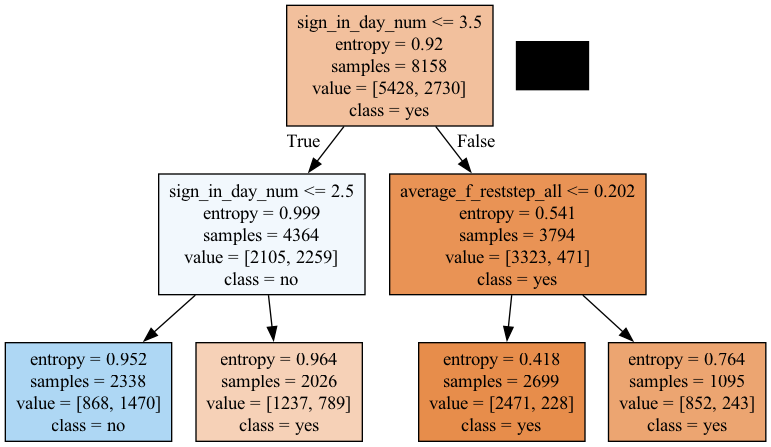

In [588]:
from IPython.display import Image
Image(filename='tree.png')

因以上归一化后数据和原数据的表现相似，后续均用归一化数据。

## 2.3 logistic regression

In [709]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(penalty='l2',solver='liblinear')
logistic.fit(train_x_normalized,train_y)
y_pred_logistic_dev = logistic.predict_proba(dev_x_normalized)
AUC_logistic = roc_auc_score(dev_y, y_pred_logistic_dev[:,1])
print('>> AUC_logistic: {:.4f}'.format(AUC_logistic))

>> AUC_logistic: 0.7831


## 2.4 贝叶斯

In [605]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

MNB = MultinomialNB() # 多项式朴素贝叶斯模型
BNB = BernoulliNB() # 伯努利朴素贝叶斯模型
CNB = ComplementNB() # 补码朴素贝叶斯模型

MNB.fit(train_x_normalized, train_y)
y_pred_MNB_dev = MNB.predict_proba(dev_x_normalized)
AUC_MNB = roc_auc_score(dev_y, y_pred_MNB_dev[:,1])
print('>> AUC_MNB: {:.4f}'.format(AUC_MNB))

BNB.fit(train_x_normalized, train_y)
y_pred_BNB_dev = BNB.predict_proba(dev_x_normalized)
AUC_BNB = roc_auc_score(dev_y, y_pred_BNB_dev[:,1])
print('>> AUC_BNB: {:.4f}'.format(AUC_BNB))

CNB.fit(train_x_normalized, train_y)
y_pred_CNB_dev = CNB.predict_proba(dev_x_normalized)
AUC_CNB = roc_auc_score(dev_y, y_pred_CNB_dev[:,1])
print('>> AUC_CNB: {:.4f}'.format(AUC_CNB))

>> AUC_MNB: 0.7670
>> AUC_BNB: 0.7238
>> AUC_CNB: 0.7670


## 2.5 KNN

In [357]:
from sklearn.neighbors import KNeighborsClassifier

In [612]:
def knn_param_search(x,y):
    knn_clf = KNeighborsClassifier()

    param_grid = {'n_neighbors': range(10,101,5),
                  'weights':['uniform', 'distance']
                  }

    grid_search = GridSearchCV(estimator=knn_clf, scoring='accuracy',param_grid=param_grid, cv=5)
    grid_search.fit(x, y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [613]:
best_knn = knn_param_search(train_x_normalized,train_y)
y_pred_dev = best_knn.predict_proba(dev_x_normalized)
AUC_knn = roc_auc_score(dev_y, y_pred_dev[:,1])
print('>> AUC_knn: {:.4f}'.format(AUC_knn))

{'n_neighbors': 85, 'weights': 'uniform'}
>> AUC_knn: 0.7796


## 2.6 SVM

In [677]:
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [683]:
# svm_clf = LinearSVC()
svm_clf = SVC(probability=True)
svm_clf.fit(train_x_normalized, train_y)
y_pred_svm = svm_clf.predict_proba(dev_x_normalized)
AUC_svm = roc_auc_score(dev_y, y_pred_svm[:,1])
print('>> AUC_svm: {:.4f}'.format(AUC_svm))

>> AUC_svm: 0.7587


## 2.7 集成学习

### 2.7.1 RandomForest

In [624]:
from sklearn.ensemble import RandomForestClassifier

In [625]:
def rfc_param_search(x,y):
    rfc = RandomForestClassifier(n_estimators=50, random_state=2024)

    param_grid = {'n_estimators':range(1,101,10)}

    grid_search = GridSearchCV(estimator=rfc, scoring='accuracy',param_grid=param_grid, cv=5)
    grid_search.fit(x, y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [626]:
best_rfc = rfc_param_search(train_x_normalized, train_y)
y_pred_rfc = best_rfc.predict_proba(dev_x_normalized)
AUC_rfc = roc_auc_score(dev_y, y_pred_rfc[:,1])
print('>> AUC_rfc: {:.4f}'.format(AUC_rfc))

{'n_estimators': 51}
>> AUC_rfc: 0.7659


### 2.7.2 bagging

In [687]:
def bagging_calib(num_model,base_model, train_X, train_y, num_sample_per, test_X):
    predict_result_sum = np.zeros(test_X.shape[0])
    for _ in range(num_model):
        train_num = len(train_y)
        sample_index = np.random.choice(train_num, int(num_sample_per*train_num), replace=True)
        sample_X, sample_y = train_X[sample_index],train_y[sample_index]
        X_train, X_calib, y_train, y_calib = train_test_split(
                                             sample_X, sample_y, random_state=42)
        
        base_clf = base_model
        base_clf.fit(X_train, y_train)
        calibrated_clf = CalibratedClassifierCV(
                       base_estimator=base_clf,
                       cv="prefit"
                     )
        calibrated_clf.fit(X_calib, y_calib)
        
        predict_result = calibrated_clf.predict_proba(test_X)[:,1]
        predict_result_sum += predict_result
    predict_result_sum /= num_model
    return predict_result_sum

bagging + svm

In [703]:
predict_bagging_svm_calib = bagging_calib(70,LinearSVC(),train_x_normalized,train_y,0.5,dev_x_normalized)
AUC_bagging_svm = roc_auc_score(dev_y,predict_bagging_svm_calib)
print('>> AUC_bagging_svm: {:.4f}'.format(AUC_bagging_svm))

>> AUC_bagging_svm: 0.7841


bagging + dc

In [699]:
predict_bagging_dc_calib = bagging_calib(60,DecisionTreeClassifier(max_depth=2),train_x_normalized,train_y,0.5,dev_x_normalized)
AUC_bagging_dc = roc_auc_score(dev_y,predict_bagging_dc_calib)
print('>> AUC_bagging_dc: {:.4f}'.format(AUC_bagging_dc))

>> AUC_bagging_dc: 0.7845


bagging + knn

In [705]:
predict_bagging_knn_calib = bagging_calib(70,KNeighborsClassifier(n_neighbors=85),train_x_normalized,train_y,0.5,dev_x_normalized)
AUC_bagging_knn = roc_auc_score(dev_y,predict_bagging_knn_calib)
print('>> AUC_bagging_dc: {:.4f}'.format(AUC_bagging_knn))

>> AUC_bagging_dc: 0.7838


bagging + bayes

In [718]:
predict_bagging_bayes_calib = bagging_calib(100,MultinomialNB(),train_x_normalized,train_y,0.5,dev_x_normalized)
AUC_bagging_bayes = roc_auc_score(dev_y,predict_bagging_bayes_calib)
print('>> AUC_bagging_dc: {:.4f}'.format(AUC_bagging_bayes))

>> AUC_bagging_dc: 0.7671


### 2.7.3 averaging

In [728]:
def avg(base_models, train_X, train_y, test_X):
    num_model = len(base_models)
    predict_result_sum = np.zeros(test_X.shape[0])
    for base_model in base_models:
        
        base_model.fit(train_X, train_y)
    
        predict_result = base_model.predict_proba(test_X)[:,1]
        predict_result_sum += predict_result
    predict_result_sum /= num_model
    return predict_result_sum

In [731]:
base_models = [
    LogisticRegression(penalty='l2',solver='liblinear'),
    DecisionTreeClassifier(max_depth=3),
    SVC(probability=True),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=85)
]

In [730]:
predict_avg = avg(base_models, train_x_normalized, train_y, dev_x_normalized)
AUC_bagging_avg = roc_auc_score(dev_y,predict_avg)
print('>> AUC_bagging_avg: {:.4f}'.format(AUC_bagging_avg))

>> AUC_bagging_avg: 0.7842


### 2.7.4 adaboost

In [110]:
from sklearn.ensemble import AdaBoostClassifier

adaboost + dc

In [739]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=2024)
ada_classifier_dc = AdaBoostClassifier(base_estimator=tree_clf, n_estimators=50, random_state=2024)

ada_classifier_dc.fit(train_x_normalized, train_y)
Y_pred_ada_avg = ada_classifier_dc.predict_proba(dev_x_normalized)
print('>> AUC_bagging_avg: {:.4f}'.format(AUC_bagging_avg))

>> AUC_bagging_avg: 0.7842


adaboost + svm

In [740]:
svm_clf = SVC(probability = True)
ada_classifier_svm = AdaBoostClassifier(base_estimator=svm_clf, n_estimators=50, random_state=2024)

ada_classifier_svm.fit(train_x_normalized, train_y)
Y_pred_ada_svm = ada_classifier_dc.predict_proba(dev_x_normalized)
print('>> AUC_bagging_svm: {:.4f}'.format(AUC_bagging_svm))

>> AUC_bagging_svm: 0.7841


### 2.7.3 stacking

In [724]:
base_models = [
    LogisticRegression(penalty='l2',solver='liblinear'),
    DecisionTreeClassifier(max_depth=3),
    SVC(probability=True),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=85)
]

X_train_meta = []
X_dev_meta = []
X_test_meta = []
for model in base_models:
    model.fit(train_x_normalized, train_y)
    X_train_meta.append(model.predict_proba(train_x_normalized))
    X_dev_meta.append(model.predict_proba(dev_x_normalized))
    X_test_meta.append(model.predict_proba(test_x_normalized))

X_train_meta = np.concatenate(X_train_meta, axis=1)
X_dev_meta = np.concatenate(X_dev_meta, axis=1)
X_test_meta = np.concatenate(X_test_meta, axis=1)

meta_model = LogisticRegression(penalty='l2',solver='liblinear')
meta_model.fit(X_train_meta, train_y)

y_pred_dev = meta_model.predict(X_dev_meta)
y_pred_test = meta_model.predict_proba(X_test_meta)
AUC_stacking = roc_auc_score(dev_y, y_pred_dev)
print('>> AUC_stacking: {:.4f}'.format(AUC_stacking))

>> AUC_stacking: 0.6957


经过比较多个模型的结果，我们选择bagging+dc

In [741]:
predict_bagging_dc_calib = bagging_calib(60,DecisionTreeClassifier(max_depth=2),train_x_normalized,train_y,0.5,test_x_normalized)

In [743]:
pre_df = pd.DataFrame({'ID':range(1,2774),'Prediction':predict_bagging_dc_calib})
print(pre_df)
pre_df.to_csv('output_bagging_dc.csv', index=False)

        ID  Prediction
0        1    0.111493
1        2    0.116875
2        3    0.579939
3        4    0.120322
4        5    0.111493
...    ...         ...
2768  2769    0.383500
2769  2770    0.113465
2770  2771    0.135367
2771  2772    0.586003
2772  2773    0.579939

[2773 rows x 2 columns]
